In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [3]:
INPUT_DIR = os.path.join("/mnt/data/Smart-Detect/Segmentation/", "input_segmentation")

SEGMENTATION_MODEL = os.path.join(INPUT_DIR, "unet_lung_seg.hdf5")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")

SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")

SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")

SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, "pulmonary-chest-xray-abnormalities")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR,"ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png_preproc")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png_preproc")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "leftMask")
print(MONTGOMERY_LEFT_MASK_DIR)
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "rightMask")

MANUAL_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR,"Manual_seg")
MANUAL_IMAGE_DIR = os.path.join(MANUAL_TRAIN_DIR, "CXR_png_preproc")
MANUAL_MASK_DIR = os.path.join(MANUAL_TRAIN_DIR, "masks")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=56

#Desv
#EPOCHS=16

/mnt/data/Smart-Detect/Segmentation/input_segmentation/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask


In [ ]:
segmentation_model = load_model(SEGMENTATION_MODEL, \
                                custom_objects={'dice_coef_loss': dice_coef_loss, \
                                                'dice_coef': dice_coef})

segmentation_model.summary()

NameError: name 'SEGMENTATION_MODEL' is not defined

In [ ]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
print(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir[0:20]
montgomery_train= montgomery_left_mask_dir[20:]

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

  0%|          | 0/138 [00:00<?, ?it/s]

/mnt/data/Smart-Detect/Segmentation/input_segmentation/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/*.png


100%|██████████| 138/138 [00:50<00:00,  2.73it/s]


In [ ]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

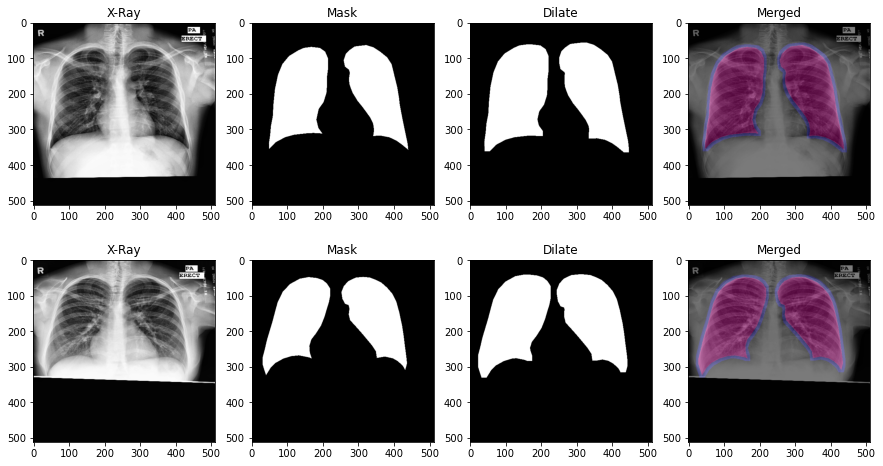

In [ ]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_test = shenzhen_mask_dir[0:20]
shenzhen_train= shenzhen_mask_dir[20:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [01:58<00:00,  4.78it/s]


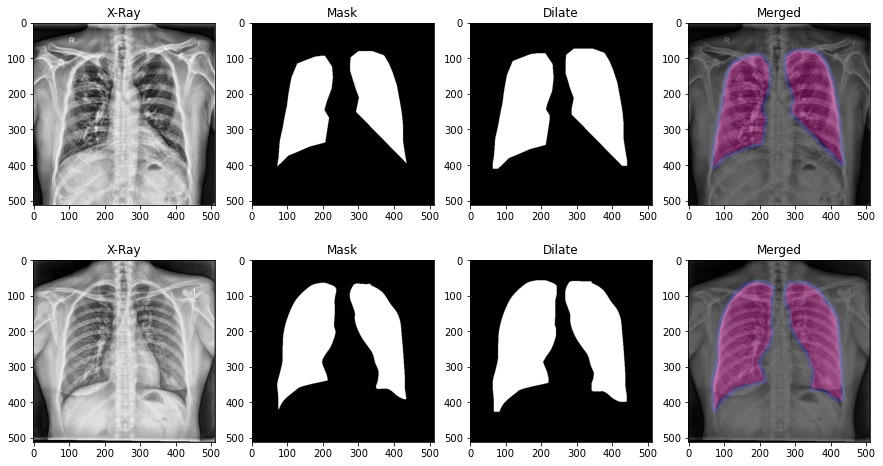

In [ ]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
manual_mask_dir = glob(os.path.join(MANUAL_MASK_DIR, '*.png'))
manual_test = manual_mask_dir[0:10]
manual_train= manual_mask_dir[10:]

for mask_file in tqdm(manual_mask_dir):
    base_file = os.path.basename(mask_file)
    image_file = os.path.join(MANUAL_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    #image = (image*(-1))+255
    #npy = image /255
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in manual_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 188/188 [00:05<00:00, 31.66it/s]


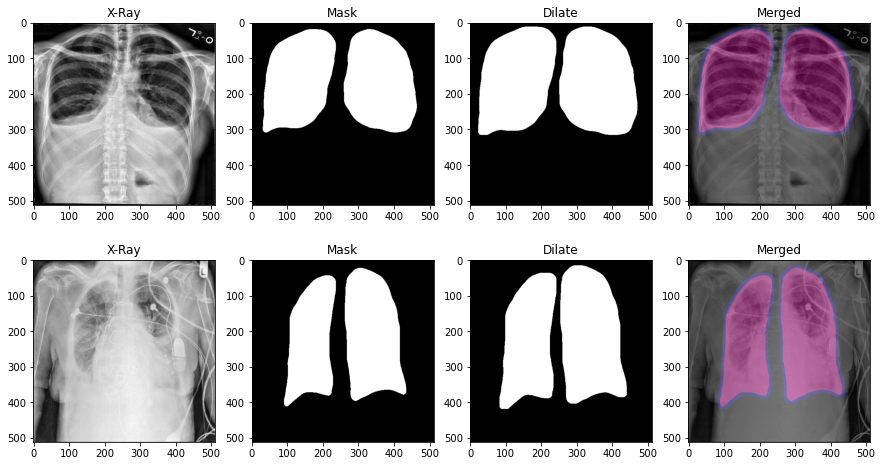

In [ ]:
base_file = os.path.basename(manual_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(manual_test[0])
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(842, 200, 842, 842)

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [ ]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(50, 2)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

421/421 [==============================] - 86s 205ms/step - loss: -0.7151 - dice_coef: 0.7151 - binary_accuracy: 0.7669 - val_loss: -0.7703 - val_dice_coef: 0.7703 - val_binary_accuracy: 0.8741

Epoch 00004: loss improved from -0.69161 to -0.71510, saving model to unet_lung_seg.hdf5
Epoch 5/56
421/421 [==============================] - 83s 197ms/step - loss: -0.7248 - dice_coef: 0.7248 - binary_accuracy: 0.7819 - val_loss: -0.8126 - val_dice_coef: 0.8126 - val_binary_accuracy: 0.9116

Epoch 00005: loss improved from -0.71510 to -0.72481, saving model to unet_lung_seg.hdf5
Epoch 6/56
421/421 [==============================] - 94s 224ms/step - loss: -0.7963 - dice_coef: 0.7963 - binary_accuracy: 0.8575 - val_loss: -0.8266 - val_dice_coef: 0.8266 - val_binary_accuracy: 0.9182

Epoch 00006: loss improved from -0.72481 to -0.79625, saving model to unet_lung_seg.hdf5
Epoch 7/56
421/421 [==============================] - 125s 296ms/step - loss: -0.8286 - dice_coef: 0.8286 - binary_accuracy: 0

421/421 [==============================] - 126s 299ms/step - loss: -0.9234 - dice_coef: 0.9234 - binary_accuracy: 0.9489 - val_loss: -0.9567 - val_dice_coef: 0.9567 - val_binary_accuracy: 0.9769

Epoch 00032: loss improved from -0.92177 to -0.92341, saving model to unet_lung_seg.hdf5
Epoch 33/56
421/421 [==============================] - 122s 290ms/step - loss: -0.9235 - dice_coef: 0.9235 - binary_accuracy: 0.9493 - val_loss: -0.9513 - val_dice_coef: 0.9513 - val_binary_accuracy: 0.9740

Epoch 00033: loss improved from -0.92341 to -0.92354, saving model to unet_lung_seg.hdf5
Epoch 34/56
421/421 [==============================] - 124s 293ms/step - loss: -0.9249 - dice_coef: 0.9249 - binary_accuracy: 0.9498 - val_loss: -0.9565 - val_dice_coef: 0.9565 - val_binary_accuracy: 0.9765

Epoch 00034: loss improved from -0.92354 to -0.92486, saving model to unet_lung_seg.hdf5
Epoch 35/56
421/421 [==============================] - 129s 306ms/step - loss: -0.9252 - dice_coef: 0.9252 - binary_accur

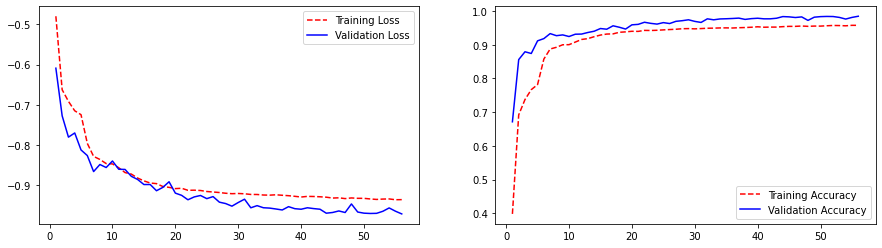

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [ ]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

50/50 [==============================] - 2s 35ms/step


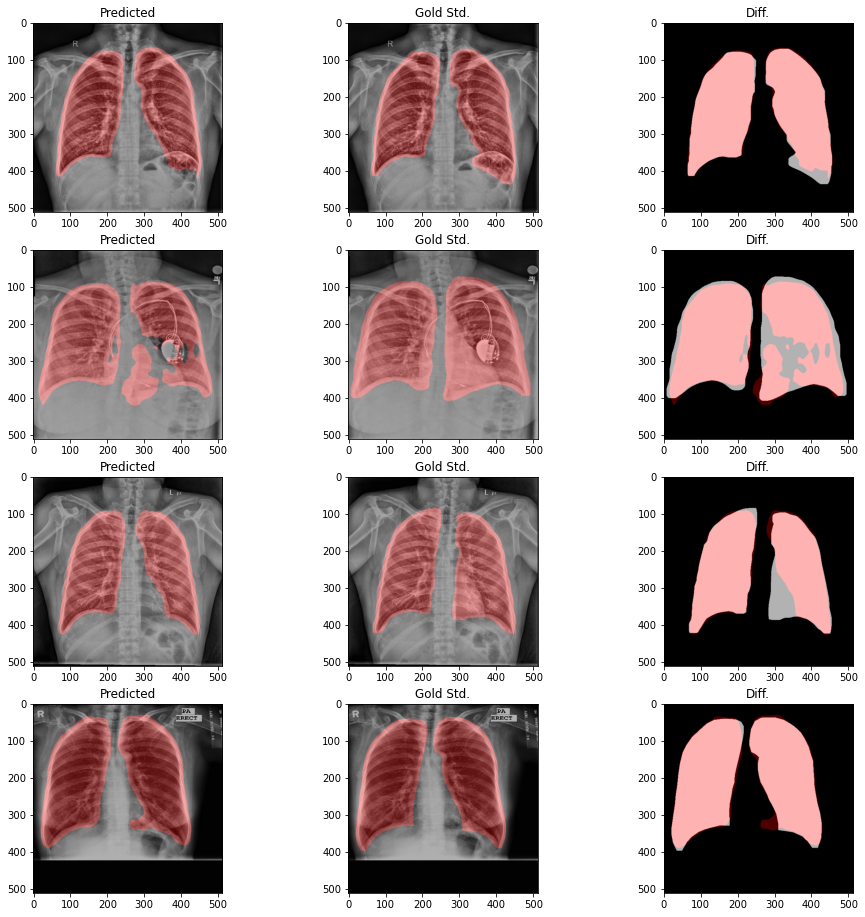

In [ ]:
image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0104_0.png")
predict_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0104_0_predict.png")
mask_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0104_0_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/00000108_000.png")
predict_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/00000108_000_predict.png")
mask_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/00000108_000_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0290_0.png")
predict_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0290_0_predict.png")
mask_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/CHNCXR_0290_0_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/MCUCXR_0040_0.png")
predict_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/MCUCXR_0040_0_predict.png")
mask_image = cv2.imread("/mnt/data/Smart-Detect/Segmentation/input_segmentation/segmentation/test/MCUCXR_0040_0_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))